In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Functions

In [3]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [4]:
def plot_hist_normalized(this_column):
    pt = PowerTransformer()
    col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    sc = StandardScaler()
    col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")
    qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
    col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")

In [5]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [6]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [7]:
def all_numeric_to_int(this_df):
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)


## Read and Clean

In [8]:
ca_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/marketing_cust_analysis_round2.csv")
ca_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type', 'month'],
      dtype='object')

### Numerical columns

#### Boxplots

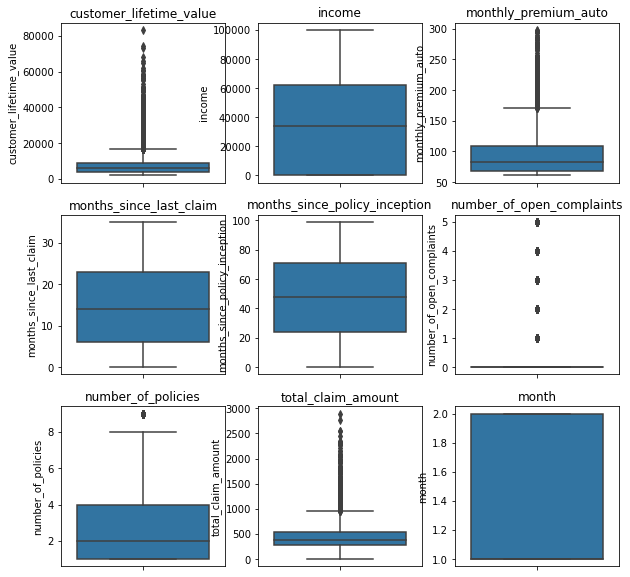

In [9]:
boxplots_for_all_numerical_cols(ca_df)

#### Check for NaNs

In [10]:
for col in split_column_names_by(ca_df)[0]:
    print(f"{col}: {ca_df[col].isna().sum()}")

customer_lifetime_value: 0
income: 0
monthly_premium_auto: 0
months_since_last_claim: 633
months_since_policy_inception: 0
number_of_open_complaints: 633
number_of_policies: 0
total_claim_amount: 0
month: 0


In [11]:
# ca_df["months_since_last_claim"].value_counts()

NaN will be replaced with mean of months_since_last_claim

In [12]:
ca_df["months_since_last_claim"].fillna(np.mean(ca_df["months_since_last_claim"]), inplace=True)

**Change appropriate numerical columns to categorical**

In [13]:
for col in ["number_of_open_complaints","number_of_policies", "month"]:
    ca_df[col] = ca_df[col].astype('category')

*placeholder*

**Categorical columns**

In [14]:
print(split_column_names_by(ca_df)[1])

['customer', 'state', 'response', 'coverage', 'education', 'effective_to_date', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


**drop some columns:**
+ customer → kind of primary key
+ effective to date → does not seem to have an effect for the model

In [15]:
ca_df.drop(["customer", "effective_to_date"], axis=1, inplace=True)

In [16]:
print(split_column_names_by(ca_df)[1])

['state', 'response', 'coverage', 'education', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


In [17]:
# ca_df["vehicle_size"].isna().sum()
ca_df["location_code"].value_counts()

Suburban    6902
Rural       2116
Urban       1892
Name: location_code, dtype: int64

## Findings

### No further adjustments (QuantileTransformer)

Error metrics **Test**:
+     R² = 0.744337
+ adj_R² = 0.740531

Error metrics **Train**:
+     R² = 0.740341
+ adj_R² = 0.736475

### No further adjustments (StandardScaler)

Error metrics **Test**:
+     R² = 0.774525
+ adj_R² = 0.771168

Error metrics **Train**:
+     R² = 0.768866
+ adj_R² = 0.765425

### Drop all income 0 rows  (QuantileTransformer)

`ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]`

Error metrics **Test**:
+     R² = 0.759750
+ adj_R² = 0.755024

Error metrics **Train**:
+     R² = 0.767118
+ adj_R² = 0.762536

### Income 0 replaced with mean (excluding the 0's for the calculation of the mean)  (QuantileTransformer)

`ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df_adj[ca_df["income"] != 0]["income"]))`

Error metrics **Test**:
+     R² = 0.744460
+ adj_R² = 0.740655

Error metrics **Train**:
+     R² = 0.740280
+ adj_R² = 0.736413

### Removing outliers from all numerical columns (StandardScaler)

`from scipy import stats
 ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj.select_dtypes(include=np.number))) < 3).all(axis=1)]`

Error metrics **Test**:
+     R² = 0.761369
+ adj_R² = 0.757620

Error metrics **Train**:
+     R² = 0.759149
+ adj_R² = 0.755366

### Removing rows with outliers only from cust_lifetime_value (StandardScaler)

Error metrics **Test**:
+     R² = 0.754979
+ adj_R² = 0.751243

Error metrics **Train**:
+     R² = 0.777641
+ adj_R² = 0.774250

### Removing rows with outliers only from cust_lifetime_value and dropping 0 income (StandardScaler)
`from scipy import stats
 ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]
 ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]`

Error metrics **Test**:
+     R² = 0.814381
+ adj_R² = 0.810638

Error metrics **Train**:
+     R² = 0.802231
+ adj_R² = 0.798243

### Removing rows with outliers only from cust_lifetime_value and replacing 0 income with mean (s.a.) (StandardScaler)
`from scipy import stats
 ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df_adj[ca_df["income"] != 0]["income"]))
 ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]`

Error metrics **Test**:
+ R²     = 0.754959
+ adj_R² = 0.751223

Error metrics **Train**:
+ R²     = 0.777640
+ adj_R² = 0.774249

### Removing rows with outliers only from cust_lifetime_value and dropping 0 income (PowerTransformer)
`from scipy import stats
 ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]
 ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]`

Error metrics **Test**:
+     R² = 0.729575
+ adj_R² = 0.725452

Error metrics **Train**:
+     R² = 0.756960
+ adj_R² = 0.753254

### placeholder

Error metrics **Test**:

R² =
adj_R² =


Error metrics **Train**:

R² =
adj_R² =

### placeholder

Error metrics **Test**:

R² =
adj_R² =


Error metrics **Train**:

R² =
adj_R² =

### placeholder

Error metrics **Test**:

R² =
adj_R² =


Error metrics **Train**:

R² =
adj_R² =

## Adjust the DataFrame to finetune the model

### Dataframe set up

In [18]:
ca_df_adj = ca_df



In [19]:
from scipy import stats
ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]
ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]

In [20]:
len(ca_df_adj)

7928

#### Different transformations (zero income dropped)

##### Numerical

In [21]:
# boxplots_for_all_numerical_cols(split_df_by(ca_df_adj)[0])

In [22]:
# for col in split_column_names_by(ca_df_adj)[0]:
#     plot_hist_normalized(ca_df_adj[col])

##### choosing scaler

In [23]:
# qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
# ca_df_adj["customer_lifetime_value_qt"] = qt.fit_transform(ca_df_adj["customer_lifetime_value"].to_numpy().reshape(-1,1))
# ca_df_adj["income_qt"] = qt.fit_transform(ca_df_adj["income"].to_numpy().reshape(-1,1))
# ca_df_adj["monthly_premium_auto_qt"] = qt.fit_transform(ca_df_adj["monthly_premium_auto"].to_numpy().reshape(-1,1))
# ca_df_adj["months_since_last_claim_qt"] = qt.fit_transform(ca_df_adj["months_since_last_claim"].to_numpy().reshape(-1,1))
# ca_df_adj["months_since_policy_inception_qt"] = qt.fit_transform(ca_df_adj["months_since_policy_inception"].to_numpy().reshape(-1,1))
# ca_df_adj.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

sc = StandardScaler()
ca_df_adj["customer_lifetime_value_sc"] = sc.fit_transform(ca_df_adj["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_df_adj["income_sc"] = sc.fit_transform(ca_df_adj["income"].to_numpy().reshape(-1,1))
ca_df_adj["monthly_premium_auto_sc"] = sc.fit_transform(ca_df_adj["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_df_adj["months_since_last_claim_sc"] = sc.fit_transform(ca_df_adj["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_df_adj["months_since_policy_inception_sc"] = sc.fit_transform(ca_df_adj["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_df_adj.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

# pt = PowerTransformer()
# ca_df_adj["customer_lifetime_value_pt"] = pt.fit_transform(ca_df_adj["customer_lifetime_value"].to_numpy().reshape(-1,1))
# ca_df_adj["income_pt"] = pt.fit_transform(ca_df_adj["income"].to_numpy().reshape(-1,1))
# ca_df_adj["monthly_premium_auto_pt"] = pt.fit_transform(ca_df_adj["monthly_premium_auto"].to_numpy().reshape(-1,1))
# ca_df_adj["months_since_last_claim_pt"] = pt.fit_transform(ca_df_adj["months_since_last_claim"].to_numpy().reshape(-1,1))
# ca_df_adj["months_since_policy_inception_pt"] = pt.fit_transform(ca_df_adj["months_since_policy_inception"].to_numpy().reshape(-1,1))
# ca_df_adj.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)


##### Categorical

In [24]:
categoricals_features= ca_df_adj.select_dtypes("object")
len(categoricals_features)

7928

In [25]:
# for col in categoricals_features.columns:
#     print(f"{col}:\n", categoricals_features[col].value_counts(),"\n  - - - - - -")

In [26]:
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

In [27]:
cat_cols

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### X-y split

In [28]:
X=ca_df_adj.drop("total_claim_amount", axis=1)
y=ca_df_adj["total_claim_amount"]

In [29]:
X=X._get_numeric_data()
X

,customer_lifetime_value_sc,income_sc,monthly_premium_auto_sc,months_since_last_claim_sc,months_since_policy_inception_sc
0,-0.515331,-0.098213,-0.924361,-0.826332,0.154437
2,1.487737,-1.163544,0.242962,1.938153,-0.598520
3,2.946671,-0.055049,0.153168,-0.519167,-1.602462
4,0.317580,-1.100340,0.751795,0.008037,-0.598520
5,-0.527982,0.005481,-0.924361,-1.338274,0.907394
...,...,...,...,...,...
10902,-0.758376,-0.909865,-0.026420,-0.519167,-0.634375
10903,-0.917883,0.388407,-0.535254,1.528599,1.230090
10906,-0.426381,0.441530,-0.804636,-0.826332,0.728119
10907,3.255046,-0.435301,3.266031,-0.416779,0.548843


array([[<AxesSubplot:title={'center':'customer_lifetime_value_sc'}>,
        <AxesSubplot:title={'center':'income_sc'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_sc'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_sc'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_sc'}>,
        <AxesSubplot:>]], dtype=object)

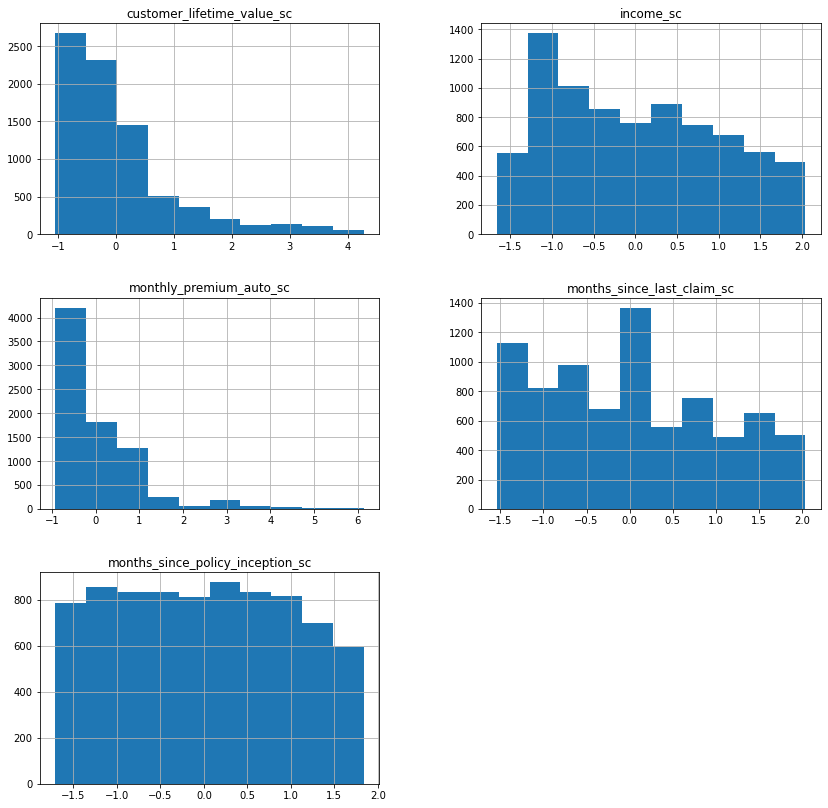

In [30]:
X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [31]:
X = pd.concat([X,cat_cols],axis=1)
X

,customer_lifetime_value_sc,income_sc,monthly_premium_auto_sc,months_since_last_claim_sc,months_since_policy_inception_sc,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,-0.515331,-0.098213,-0.924361,-0.826332,0.154437,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.487737,-1.163544,0.242962,1.938153,-0.598520,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,2.946671,-0.055049,0.153168,-0.519167,-1.602462,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.317580,-1.100340,0.751795,0.008037,-0.598520,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
5,-0.527982,0.005481,-0.924361,-1.338274,0.907394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,-0.758376,-0.909865,-0.026420,-0.519167,-0.634375,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10903,-0.917883,0.388407,-0.535254,1.528599,1.230090,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,-0.426381,0.441530,-0.804636,-0.826332,0.728119,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,3.255046,-0.435301,3.266031,-0.416779,0.548843,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### Data splitting

In [32]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### Standardize
+ Build scaling parameters on training set (mean variance) → more data as approx 80 % of sample <br>



In [33]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [34]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [35]:
X_test_scaled=std_scaler.transform(X_test)

In [36]:
# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)

#### Modeling using Statsmodels

In [37]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     496.1
Date:                Thu, 03 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:23:44   Log-Likelihood:                -33871.
No. Observations:                5549   AIC:                         6.783e+04
Df Residuals:                    5503   BIC:                         6.814e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        372.8442      1.460    255.374      0.0

In [38]:
predictions_test

array([415.24995301, 388.19090723, 450.47944826, ..., 547.55216092,
       595.81813315, 412.17121695])

In [39]:
#display adjusted R-squared
# print(model.rsquared_adj)

#### Modeling using Scikit Learn

##### Model fitting

In [40]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [41]:
model.coef_

array([ 2.51961800e+00, -7.86608098e+00,  1.56352839e+02,  7.29722123e-02,
       -7.10999614e-01,  3.89641608e-02, -2.19743559e+00,  3.12993501e-02,
        1.39064718e+00, -3.49213772e-01, -5.99944078e+00, -5.84100969e+00,
       -1.92244953e+00, -2.33268780e+00,  9.31207992e-02, -1.12175098e-01,
       -1.37134491e+00,  5.10588203e+00, -2.26664648e+00,  4.27850331e+00,
        1.85470068e+02,  9.08999055e+01, -4.98941350e+00, -7.36015534e-01,
        1.97412821e+14,  3.05677836e+13, -2.76482622e+00, -2.69874279e-02,
       -1.52394713e+14, -1.90841429e+14, -2.17896370e+14, -1.44914519e+13,
       -1.96862815e+13, -1.90511199e+13,  5.96782547e+00,  2.55229568e+00,
        2.27519826e+00, -6.50381092e-01, -1.19188283e+00,  1.83270784e+00,
       -4.78991672e+00, -6.19670988e+00, -1.10680568e+01, -9.17665012e+00,
        1.58544882e+00,  7.94475607e-01,  3.39743304e+00])

In [42]:
model.intercept_

372.8380878664714

In [43]:
model.score(X_test_scaled,y_test)

0.8143810818301225

##### Making prediction

In [44]:
y_pred=model.predict(X_test_scaled)

In [45]:
y_test

6987    376.529086
444     312.000000
6065    472.500375
1781    281.110788
3383    268.676912
           ...    
9493    365.002909
5683    542.400000
8065    513.600000
8043    833.417104
5554    345.600000
Name: total_claim_amount, Length: 2379, dtype: float64

In [46]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

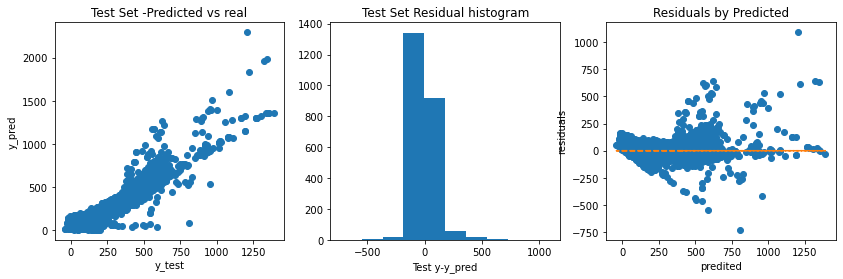

In [47]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

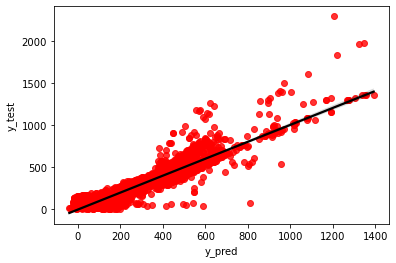

In [48]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics Test

In [49]:
# print(mse(y_test,y_pred))
# print(mae(y_test,y_pred))

In [50]:
R2=r2_score(y_test,y_pred)
R2

0.8143810818301225

In [51]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.8106384438404253

##### Error metrics Train

In [52]:
y_pred=model.predict(X_train_scaled)

In [53]:
# print(mse(y_train,y_pred))
# print(mae(y_train,y_pred))

In [54]:
R2=r2_score(y_train,y_pred)
R2

0.8022305317503428

In [55]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7982429019743951